In [1]:
import numpy
import xarray
import matplotlib.pyplot as mp
import glob
import pandas
import cartopy
import itertools
import datetime
import calendar

import dask_jobqueue
import dask.distributed
import ipywidgets
#import dask.diagnostics

useful commands

In [2]:
#!export TMPDIR=/glade/scratch/$USER/temp/
#!mkdir -p $TMPDIR

cluster = dask_jobqueue.PBSCluster(cores=36,
                                   memory='100 GB',
                                   project='UCLA0022',
                                   queue='regular',
                                   walltime='06:00:00',
                                   local_directory='/glade/scratch/baird/temp/')

In [3]:
# ask for 60 workers with these specifications
# takes about 26 . min for all 60 workers for 3hrs
cluster.start_workers(30)

In [4]:
print(cluster.job_script())

#!/bin/bash

#!/usr/bin/env bash
#PBS -N dask-worker
#PBS -q regular
#PBS -A UCLA0022
#PBS -l select=1:ncpus=36:mem=94GB
#PBS -l walltime=06:00:00
JOB_ID=${PBS_JOBID%.*}



/glade/u/home/baird/miniconda3/envs/pangeo/bin/python -m distributed.cli.dask_worker tcp://10.148.0.6:52480 --nthreads 36 --memory-limit 100.00GB --name dask-worker--${JOB_ID}-- --death-timeout 60 --local-directory /glade/scratch/baird/temp/ --interface ib0



In [29]:
client = dask.distributed.Client(cluster)
client

Client Scheduler: tcp://10.148.0.6:52480 Dashboard: http://10.148.0.6:8787/status,Cluster Workers: 30 Cores: 1080 Memory: 3.00 TB


In [ ]:
client.scheduler_info()#['workers']

In [8]:
#PRECT_root = '/ninad/NCAR_LENS/PRECT/'
#PRECT_root = '/scratch/blangenb/NCAR_LENS/PRECT/'
PRECT_root =  '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/PRECT/'

Open pre-industrial control as multi-file dataset

In [86]:
filename_list = sorted(glob.glob(PRECT_root + 'b.e11.B1850C5CN.f09_g16.005.cam.h1.PRECT.*.nc'))

#mfds = xarray.open_mfdataset([filename_list[0:3]], chunks={'lat':24, 'lon':24})
mfds = xarray.open_mfdataset([filename_list[0]], chunks={'lat':12, 'lon':12})
#mfds = xarray.open_mfdataset(filename_list[:2], chunks={'lat':24, 'lon':24})
mfds_data = mfds['PRECT']#.isel(time=slice(0,1000))

mfds_time = mfds['time'].values
mfds_lat = mfds['lat'].values
mfds_lon = mfds['lon'].values

In [87]:
mfds_lat.shape, mfds_lon.shape, mfds_data.shape

((192,), (288,), (35769, 192, 288))

In [54]:
mfds_data_persist = client.persist(mfds_data.data)

In [88]:
mfds_data_rolling_object = mfds_data.rolling(time=30, center=True)

In [ ]:
mfds_data_rolling_object_sum = mfds_data_rolling_object.sum().persist()

In [ ]:
mfds_data_rolling_

In [83]:
mfds_data_sum = client.persist(mfds_data.rolling(time=30, center=True).sum())

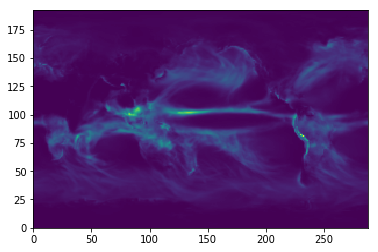

In [79]:
mp.pcolormesh(mfds_data_sum[15,:,:])

In [64]:
mfds_data_persist = mfds_data.persist()

In [67]:
mfds_tmean = mfds_data_persist.mean(axis=0).persist()

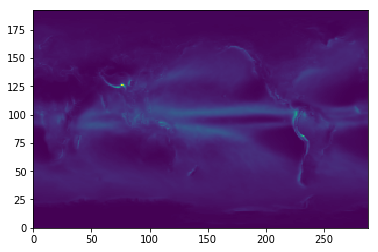

In [68]:
mp.pcolormesh(mfds_tmean)

In [69]:
mfds_tmean

<xarray.DataArray 'PRECT' (lat: 192, lon: 288)>
dask.array<shape=(192, 288), dtype=float32, chunksize=(12, 12)>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [47]:
mfds_data_persist = mfds_data.data.persist()

In [35]:
mfds_data_persist = client.persist(mfds_data)

In [37]:
mfds_data_persist = mfds_data.persist()

In [22]:
mfds_data_scatter = client.scatter(mfds_data.data)

In [25]:
mfds_data_persist = mfds_data_scatter.persist()

AttributeError: 'Future' object has no attribute 'persist'

In [85]:
client.cancel(mfds_data_persist)
client.restart()

Worker tcp://10.148.11.61:50917 restart in Job 4397435. This can be due to memory issue.
Worker tcp://10.148.11.14:58244 restart in Job 4397423. This can be due to memory issue.
Worker tcp://10.148.10.242:51581 restart in Job 4397426. This can be due to memory issue.
Worker tcp://10.148.11.16:58585 restart in Job 4397424. This can be due to memory issue.
Worker tcp://10.148.9.165:38032 restart in Job 4397416. This can be due to memory issue.
Worker tcp://10.148.11.47:53924 restart in Job 4397429. This can be due to memory issue.
Worker tcp://10.148.10.244:40386 restart in Job 4397427. This can be due to memory issue.
Worker tcp://10.148.11.61:41150 restart in Job 4397435. This can be due to memory issue.
Worker tcp://10.148.11.76:57165 restart in Job 4397438. This can be due to memory issue.
Worker tcp://10.148.9.179:46653 restart in Job 4397422. This can be due to memory issue.
Worker tcp://10.148.11.42:45233 restart in Job 4397428. This can be due to memory issue.
Worker tcp://10.148

Client Scheduler: tcp://10.148.0.6:52480 Dashboard: http://10.148.0.6:8787/status,Cluster Workers: 30 Cores: 1080 Memory: 3.00 TB


In [12]:
mfds_data.data

dask.array<open_dataset-6e35be37a607d926c3801bd0f8518cb4PRECT, shape=(35769, 192, 288), dtype=float32, chunksize=(35769, 12, 12)>

In [ ]:
mfds_data = client.persist(mfds_data.data) # same as mfds_data.data.persist() ?

In [ ]:
client.cancel(mfds_data)

In [ ]:
client.cancel(mfds_data)

In [ ]:
# from http://matthewrocklin.com/blog/work/2017/01/12/dask-dataframes
mfds_data_nday_rolling_sum = client.persist(mfds_data.rolling(time=30, center=True).sum())

### doesn't work...

In [ ]:
mfds_data = client.persist(mfds_data)

In [ ]:
del(mfds_data)

In [ ]:
client.cancel(mfds_data)

In [ ]:
mfds_data_nday_rolling_sum = mfds_data.rolling(time=30, center=True).sum()

In [ ]:
mfds_data_nday_rolling_sum.to_netcdf('/glade/scratch/baird/temp/netcdf_outfile.nc', unlimited_dims='time')

In [ ]:
mfds_data_nday_rolling_sum = client.compute(mfds_data_nday_rolling_sum)

In [ ]:
mfds_data_nday_rolling_sum

In [ ]:
mfds_data_nday_rolling_sum.to_netcdf('/glade/scratch/baird/temp/netcdf_output.nc', unlimited_dims='time')

In [ ]:
mfds_data = mfds_data.data.persist()

In [ ]:
mfds_data_tmean = mfds_data.mean(axis=0)

In [ ]:
mp.pcolormesh(mfds_data_tmean)

In [ ]:
mfds_data = mfds_data.persist()

In [ ]:
mfds_data

In [ ]:
## to cancel a persist:
#client.cancel(mfds_data)

1. pull out time and specific months
2. calculate the number of days in those months
3. other stuff

In [ ]:
event_size = 30 # days
season = 'ONDJFM'; month_numbers = [10,11,12,1,2,3]
time_data_indices = [t.month in month_numbers for t in mfds_time]

ndays = sum([calendar.monthrange(1979,m)[1] for m in month_numbers])

calculate an N-day rolling sum (corresponding to ```event_size```)  
*takes about 45 min to an hour on 50 cores*

In [ ]:
mfds_data = mfds_data.persist()

In [ ]:
print(mfds_data.dims)
print(mfds_data.coords)
print()
print(mfds_data)

In [ ]:
mfds_data.data

In [ ]:
mfds_data_nday_rolling_sum = mfds_data.rolling(time=30, center=True).sum()

In [ ]:
mfds_data_nday_rolling_sum

In [ ]:
return_period = 100 # in years
events_per_year = ndays/event_size #152/30

return_val_perc = 100*(1-1/(return_period*events_per_year))
return_val_fraction = (1-1/(return_period*events_per_year))
print(return_val_perc)

WORKED ON SMALL DATA

TRYING FOR LARGER DATA SET

In [ ]:
mfds_data = mfds_data.persist()

client.cancel(mfds_data)

def calc_perc(x, q=return_val_fraction):
    return(numpy.nanpercentile(x, q=return_val_fraction, axis=0))

doesn't compute things yet, just applies function to all chunks:

In [ ]:
result = dask.array.apply_along_axis(calc_perc, arr=mfds_data.data, axis=0)

now do the computation

In [ ]:
perc_calculation = result.compute()

In [ ]:
mp.pcolormesh(perc_calculation*86400.*1000.)
mp.colorbar()

In [ ]:
output_da = xarray.DataArray(perc_calculation*86400.*1000., name='100yr_30dsum_return_values', 
                             coords={'lon':lon_total,'lat':lat_total},
                             dims={'lat','lon'}, attrs={'units':'kg m s-1'})

output_df = xarray.Dataset({'100yr_30dsum_return_values':output_da})

In [ ]:
output_da

In [ ]:
output_df

In [ ]:
output_df.to_netcdf('pic_100yr_30dsum_return_values.nc')

In [ ]:
!ls *.nc